In [1]:
import random


def sample_constraints(prob_list):
    """
    Sample the number of constraints based on the given probabilities.
    """
    total_prob = sum(p for _, p in prob_list)
    r = random.uniform(0, total_prob)
    upto = 0
    for c, p in prob_list:
        if upto + p >= r:
            return c
        upto += p

def generate_random_adjacency(num_atoms, prob_list):
    """
    Generate random adjacency matrix with constraints represented as a set of tuples.
    """
    constraints_dict = set()
    
    # Create a list of atoms
    atom_list = list(range(num_atoms))
    
    # Sample the number of constraints for each atom
    for atom in atom_list:
        num_constraints = sample_constraints(prob_list)
        
        # Create constraints
        attempts = 0
        while num_constraints > 0 and attempts < num_atoms * 2:
            other_atom = random.choice(atom_list)
            
            # Check for self-loop and redundancy
            if atom != other_atom and (atom, other_atom) not in constraints_dict and (other_atom, atom) not in constraints_dict:
                constraints_dict.add((atom, other_atom))
                num_constraints -= 1
            
            attempts += 1
            
    return constraints_dict

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import nglview as nv
def visualize_coordinates(x, scale=1.0, colors=None):
    """
    Visualize 3D coordinates using nglview.

    Parameters:
        x (numpy array): The 3D coordinates.
        scale (float): The scaling factor for coordinates.
        colors (list of list): Colors to be used for each node.
    """
    view = nv.NGLWidget()
    if colors is None:
        colors = [[1, 1, 1]] * len(x)  # Default to white

    for i, coord in enumerate(x):
        scaled_coord = coord * scale
        color = colors[i]
        view.shape.add_sphere(scaled_coord.tolist(), color, 1.0)

    return view

Generated constraints: {(1, 3), (6, 0), (2, 1), (2, 5), (3, 6), (1, 0), (4, 0)}


/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


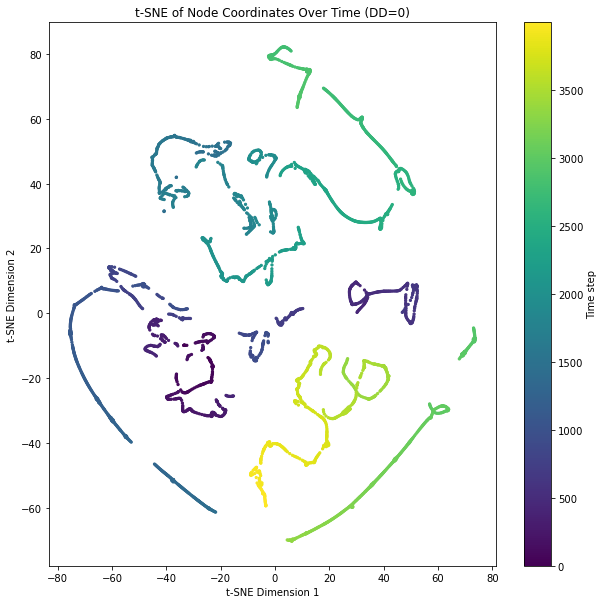

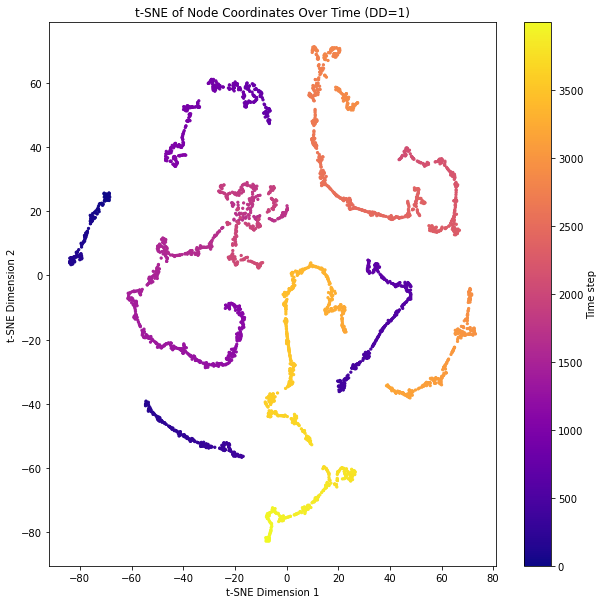

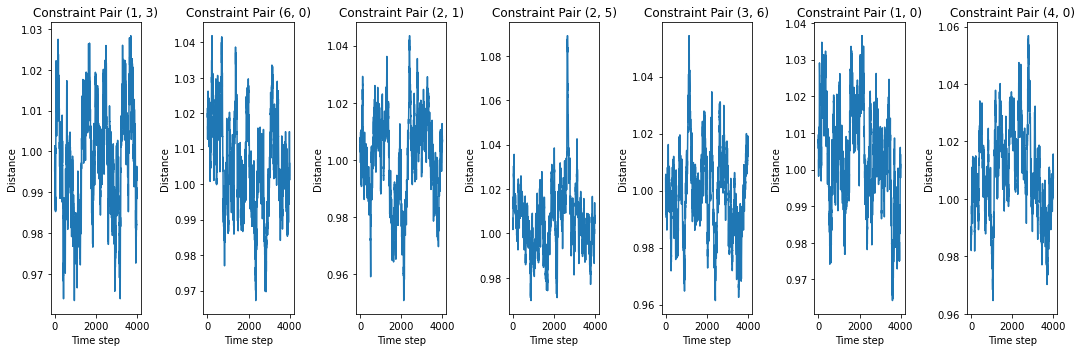

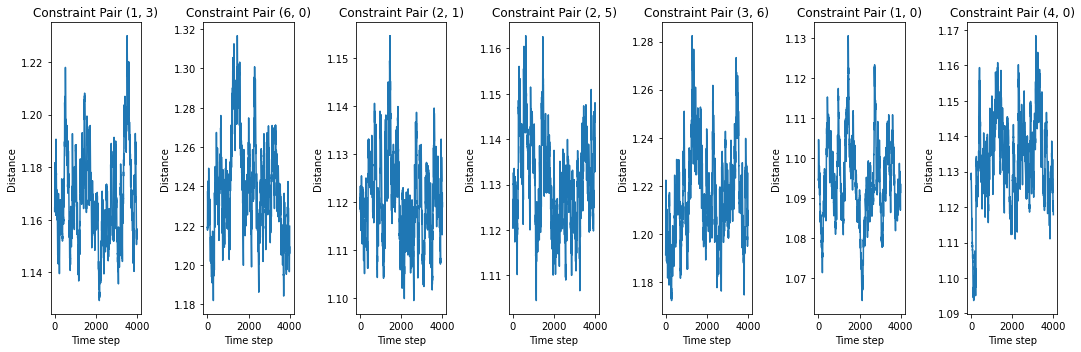

In [554]:

def plot_energy(e):    
    # Generate the timesteps
    timesteps = list(range(len(e)))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, e, marker='o', linestyle='-')

    # Label the axes and the plot
    plt.xlabel('Timestep')
    plt.ylabel('Energy')
    plt.title('Energy Over Timesteps')

    # Show the plot
    return plt.show()
# Function to compute the nullspace using SVD
def svd_nullspace(A, atol=1e-3, rtol=0):
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s > tol).sum()
    ns = vh[nnz:].conj().T
    return ns
def lennard_jones(r):
    # Computes the Lennard-Jones potential and its gradient
    E = 4 * ((1 / r)**12 - (1 / r)**6)
    grad_E = 4 * (-12 / r**13 + 6 / r**7)
    return E, grad_E

def simulate_LJ(x):
    M, N = x.shape
    grad_V_LJ = np.zeros((M, N))
    Esum = 0.0  # Initialize the sum of all Lennard-Jones potentials

    for i in range(M):
        for j in range(i + 1, M):
            dist_ij = np.linalg.norm(x[i] - x[j])
            E, grad_E = lennard_jones(dist_ij)
            Esum += E  # Add the potential to the sum

            direction = (x[i] - x[j]) / dist_ij
            force = grad_E * direction
            grad_V_LJ[i] += force
            grad_V_LJ[j] -= force  # Newton's third law

    return grad_V_LJ, Esum
import numpy as np
def svd_nullspace(A, atol=1e-3, rtol=0):
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s > tol).sum()
    ns = vh[nnz:].conj().T
    return ns


def simulate(DD = 0,constraints_dict=None ):
    # Simulation Parameters
    T = 6000
    M = 7  # Number of nodes
    N = 3  # Number of dimensions
    D = 0.02  # Diffusion coefficient
    dt = 0.01#0.003  # Time step
#     constraints_dict = {(1, 2), (2, 3), (3, 4), (1,4), (1,3), (0,4)}  # Constraint pairs
    num_atoms = M
    prob_list = [[0, 0.1], [1, 0.5], [2, 0.3], [3, 0.1]]
    if constraints_dict is None:
        constraints_dict = generate_random_adjacency(num_atoms, prob_list)
        print("Generated constraints:", constraints_dict)
    # Initialize positions of nodes in N dimensions
    x = np.random.rand(M, N)
    trajectory = [x.flatten().copy()]
    distances = []
    distance_vector = np.zeros(len(constraints_dict))
    etraj = []

    for t in range(T):
        # Initialize constraint gradient matrix and constraint value vector
        A_matrix = np.zeros((len(constraints_dict), M * N))
        b_vector = np.zeros(len(constraints_dict))
        Esum = 0

        for idx, (i, j) in enumerate(constraints_dict):
            dist_ij = np.linalg.norm(x[i] - x[j])
            constraint_value = dist_ij ** 2 - 1
            gradient_ij = 2 * (x[i] - x[j])
            A_matrix[idx, i * N:(i + 1) * N] = gradient_ij
            A_matrix[idx, j * N:(j + 1) * N] = -gradient_ij
            b_vector[idx] = constraint_value
            distance_vector[idx] = dist_ij

        # SVD for solving Lagrange multipliers
        u, s, vh = np.linalg.svd(A_matrix @ A_matrix.T)
        lambda_vector = vh.T @ np.linalg.inv(np.diag(s) + 1e-12) @ u.T @ b_vector
        
        # Compute drift term (mu)
        mu = np.sum(A_matrix.T * lambda_vector, axis=1)

        # Calculate the gradient of the Lennard-Jones potential for all pairs
        grad_V_LJ, Esum = simulate_LJ(x) #np.ones_like(simulate_LJ(x))
        etraj.append(Esum.copy())
        
        grad_V_LJ = np.clip(grad_V_LJ,-10,10)
#         print(grad_V_LJ)
        # Flatten the gradient to match dimensions
        grad_V_LJ_flatten = grad_V_LJ.flatten()

        # Find nullspace using SVD
        NN = svd_nullspace(A_matrix)
        
        # Project the gradient onto the nullspace
        grad_V_projected = NN @ (NN.T @ grad_V_LJ_flatten)
        
        # Update mu to include the projected LJ gradient
        mu += grad_V_projected
        # Assume mu is a numpy array with shape (M * N,)
        mu_mean = np.mean(mu.reshape(-1, N), axis=0)  # Calculate the mean for each dimension
        mu_centered = mu.reshape(-1, N) - mu_mean  # Subtract the mean from each component
        mu = mu_centered.flatten() 
        # Update positions
        D_t = D * NN @ NN.T
        if DD == 0:
            D_t = D*np.eye(D_t.shape[0])/200

        dx = np.random.multivariate_normal(- mu * dt, 2 * D_t * dt )
        dx_reshaped = dx.reshape(M, N)  # Reshape dx into (M, N) dimensions
        x = x + dx_reshaped

        # Store trajectory
        trajectory.append(x.flatten().copy())
        distances.append(distance_vector.copy())
        etraj.append(Esum)

    return trajectory, distances, constraints_dict, etraj, _





trajectory, distances, constraints_dict, entraj, _ = simulate(DD = 0)
Dtrajectory, Ddistances, constraints_dict, Detraj,_ = simulate(DD = 1, constraints_dict=constraints_dict)

plotts = 4000

# Convert trajectory to numpy array and apply t-SNE
trajectory = np.array(trajectory[-plotts:])
Dtrajectory = np.array(Dtrajectory[-plotts:])
entraj = np.array(entraj[-plotts:])
Detraj = np.array(Detraj[-plotts:])

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Perform t-SNE transformation
tsne_results = tsne.fit_transform(trajectory)
Dtsne_results = tsne.fit_transform(Dtrajectory)

# Plotting t-SNE results for DD=0
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(len(tsne_results)), cmap='viridis', s=5)
plt.colorbar(label='Time step')
plt.title("t-SNE of Node Coordinates Over Time (DD=0)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Plotting t-SNE results for DD=1
plt.figure(figsize=(10, 10))
plt.scatter(Dtsne_results[:, 0], Dtsne_results[:, 1], c=range(len(Dtsne_results)), cmap='plasma', s=5)
plt.colorbar(label='Time step')
plt.title("t-SNE of Node Coordinates Over Time (DD=1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

distances = np.array(distances)[-plotts:]

# Plotting the distances over time for each constraint
fig, axes = plt.subplots(1, len(constraints_dict), figsize=(15, 5))
for ax, ((i, j), distance_vector) in zip(axes, zip(constraints_dict, distances.T)):
    ax.plot(distance_vector)
    ax.set_title(f"Constraint Pair ({i}, {j})")
    ax.set_xlabel('Time step')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()
Ddistances = np.array(Ddistances)[-plotts:]

# Plotting the distances over time for each constraint
fig, axes = plt.subplots(1, len(constraints_dict), figsize=(15, 5))
for ax, ((i, j), distance_vector) in zip(axes, zip(constraints_dict, Ddistances.T)):
    ax.plot(distance_vector)
    ax.set_title(f"Constraint Pair ({i}, {j})")
    ax.set_xlabel('Time step')
    ax.set_ylabel('Distance')

plt.tight_layout()
plt.show()

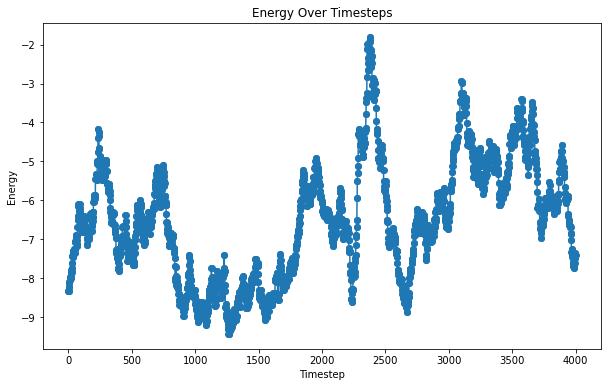

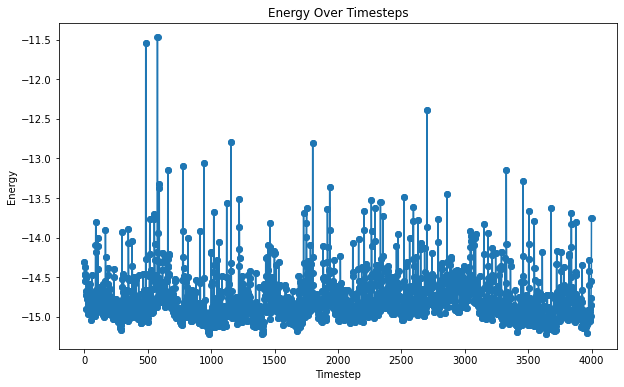

In [555]:
plot_energy(entraj)
plot_energy(Detraj)

In [556]:
view = visualize_coordinates(trajectory[-10].reshape(-1,3), scale=10.0)
view

NGLWidget()

In [557]:
view = visualize_coordinates(Dtrajectory[-10].reshape(-1,3), scale=10.0)
view

NGLWidget()

In [ ]:
# Detraj

In [ ]:
# Ddistances

Generated constraints: {(17, 18), (2, 6), (3, 12), (10, 4), (3, 0), (4, 18), (10, 13), (12, 13), (16, 8), (8, 9), (11, 0), (14, 12), (14, 1), (18, 6)}


/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


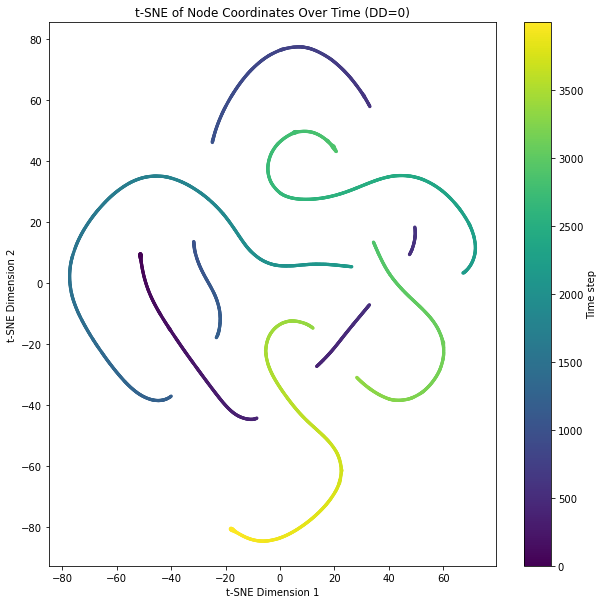

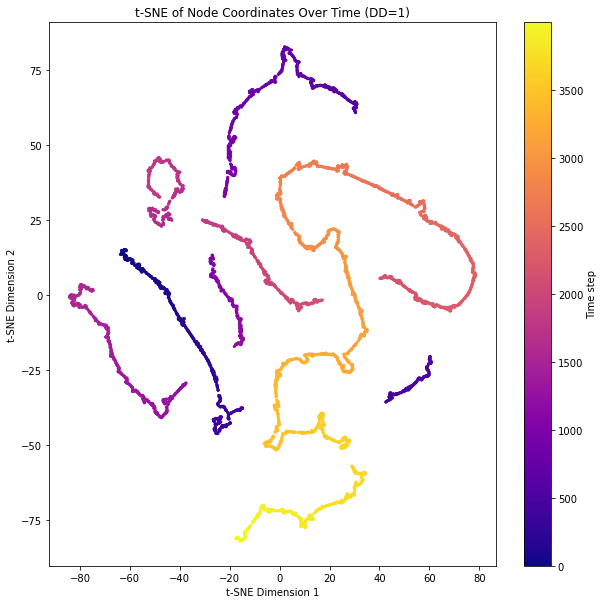

In [16]:
'''
implicit boltzman distribution
'''

def plot_energy(e):    
    # Generate the timesteps
    timesteps = list(range(len(e)))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, e, marker='o', linestyle='-')

    # Label the axes and the plot
    plt.xlabel('Timestep')
    plt.ylabel('Energy')
    plt.title('Energy Over Timesteps')

    # Show the plot
    return plt.show()
# Function to compute the nullspace using SVD
def svd_nullspace(A, atol=1e-3, rtol=0):
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s > tol).sum()
    ns = vh[nnz:].conj().T
    return ns
def lennard_jones(r):
    # Computes the Lennard-Jones potential and its gradient
    E = 4 * ((1 / r)**12 - (1 / r)**6)
    grad_E = 4 * (-12 / r**13 + 6 / r**7)
    return E, grad_E

def simulate_LJ(x):
    M, N = x.shape
    grad_V_LJ = np.zeros((M, N))
    Esum = 0.0  # Initialize the sum of all Lennard-Jones potentials

    for i in range(M):
        for j in range(i + 1, M):
            dist_ij = np.linalg.norm(x[i] - x[j])
            E, grad_E = lennard_jones(dist_ij)
            Esum += E  # Add the potential to the sum

            direction = (x[i] - x[j]) / dist_ij
            force = grad_E * direction
            grad_V_LJ[i] += force
            grad_V_LJ[j] -= force  # Newton's third law

    return grad_V_LJ, Esum
import numpy as np
def svd_nullspace(A, atol=1e-3, rtol=0):
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s > tol).sum()
    ns = vh[nnz:].conj().T
    return ns




def simulate_p(DD = 0,constraints_dict=None, beta = 1.0, alpha = 100.0 ):
    # Simulation Parameters
    T = 20000
    M = 20  # Number of nodes
    N = 3  # Number of dimensions
    D = 0.022  # Diffusion coefficient
    dt = 0.01  # Time step
#     constraints_dict = {(1, 2), (2, 3), (3, 4), (1,4), (1,3), (0,4)}  # Constraint pairs
    num_atoms = M
    prob_list = [[0, 1.0], [1, 1.0], [2, 0.5], [3, 0.0]]
    if constraints_dict is None:
        constraints_dict = generate_random_adjacency(num_atoms, prob_list)
        print("Generated constraints:", constraints_dict)
    # Initialize positions of nodes in N dimensions
    x = np.random.rand(M, N)
    trajectory = [x.flatten().copy()]
    distances = []
    distance_vector = np.zeros(len(constraints_dict))
    etraj = []
    ft_list = []

    for t in range(T):
        # Initialize constraint gradient matrix and constraint value vector
        A_matrix = np.zeros((len(constraints_dict) + 1, M * N))
        b_vector = np.zeros(len(constraints_dict) + 1)
        Esum = 0

        for idx, (i, j) in enumerate(constraints_dict):
            dist_ij = np.linalg.norm(x[i] - x[j])
            constraint_value = dist_ij ** 2 - 1
            gradient_ij = 2 * (x[i] - x[j])
            A_matrix[idx, i * N:(i + 1) * N] = gradient_ij
            A_matrix[idx, j * N:(j + 1) * N] = -gradient_ij
            b_vector[idx] = constraint_value
            distance_vector[idx] = dist_ij

        # SVD for solving Lagrange multipliers
        u, s, vh = np.linalg.svd(A_matrix @ A_matrix.T)
        lambda_vector = vh.T @ np.linalg.inv(np.diag(s) + 1e-12) @ u.T @ b_vector
        
        # Compute drift term (mu)
        mu = np.sum(A_matrix.T * lambda_vector, axis=1)

        # Calculate the gradient of the Lennard-Jones potential for all pairs
        grad_V_LJ, Esum = simulate_LJ(x) #np.ones_like(simulate_LJ(x))
        grad_V_LJ = np.clip(grad_V_LJ,-2,2)

        ################3
        ft_value = - (1 + beta) * (-Esum) + alpha + 1  # Using -Esum as the log likelihood
        ft_gradient = (1 + beta) * grad_V_LJ.flatten()  # Flatten the gradient to fit into A_matrix
        ft_list.append(ft_value.copy())
        # Insert the Boltzmann constraint into A_matrix and b_vector
        A_matrix[-1, :] = -ft_gradient*1.0e-5
#         b_vector[-1] = ft_value*1.0e-5
        #############################
        
#         etraj.append(Esum.copy())
        
#         grad_V_LJ = np.clip(grad_V_LJ,-10,10)
#         print(grad_V_LJ)
        # Flatten the gradient to match dimensions
#         grad_V_LJ_flatten = grad_V_LJ.flatten()

        # Find nullspace using SVD
        NN = svd_nullspace(A_matrix)
        
        # Project the gradient onto the nullspace
#         grad_V_projected = NN @ (NN.T @ grad_V_LJ_flatten)
        ft_gradient_projected = NN @ (NN.T @ ft_gradient)

        # Update mu to include the projected LJ gradient
        mu +=  ft_gradient_projected # + grad_V_projected# +
        # Assume mu is a numpy array with shape (M * N,)
        mu_mean = np.mean(mu.reshape(-1, N), axis=0)  # Calculate the mean for each dimension
        mu_centered = mu.reshape(-1, N) - mu_mean  # Subtract the mean from each component
        mu = mu_centered.flatten() 
        # Update positions
        D_t = D * NN @ NN.T
        if DD == 0:
            D_t = D*np.eye(D_t.shape[0])/50

        dx = np.random.multivariate_normal(- mu * dt, 2 * D_t * dt )
        dx_reshaped = dx.reshape(M, N)  # Reshape dx into (M, N) dimensions
        x = x + dx_reshaped

        # Store trajectory
        trajectory.append(x.flatten().copy())
        distances.append(distance_vector.copy())
        etraj.append(Esum.copy())

    return trajectory, distances, constraints_dict, etraj, ft_list


trajectory, distances, constraints_dict, eentraj, ft_list = simulate_p(DD = 0, constraints_dict=None)
Dtrajectory, Ddistances, constraints_dict, eDetraj, Dft_list = simulate_p(DD = 1, constraints_dict=constraints_dict)

plotts = 4000

# Convert trajectory to numpy array and apply t-SNE
trajectory = np.array(trajectory[-plotts:])
Dtrajectory = np.array(Dtrajectory[-plotts:])
entraj = np.array(eentraj[-plotts:])
Detraj = np.array(eDetraj[-plotts:])

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Perform t-SNE transformation
tsne_results = tsne.fit_transform(trajectory)
Dtsne_results = tsne.fit_transform(Dtrajectory)

# Plotting t-SNE results for DD=0
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(len(tsne_results)), cmap='viridis', s=5)
plt.colorbar(label='Time step')
plt.title("t-SNE of Node Coordinates Over Time (DD=0)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Plotting t-SNE results for DD=1
plt.figure(figsize=(10, 10))
plt.scatter(Dtsne_results[:, 0], Dtsne_results[:, 1], c=range(len(Dtsne_results)), cmap='plasma', s=5)
plt.colorbar(label='Time step')
plt.title("t-SNE of Node Coordinates Over Time (DD=1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# distances = np.array(distances)[-plotts:]

#     # Plotting the distances over time for each constraint
#     fig, axes = plt.subplots(1, len(constraints_dict), figsize=(15, 5))
#     for ax, ((i, j), distance_vector) in zip(axes, zip(constraints_dict, distances.T)):
#         ax.plot(distance_vector)
#         ax.set_title(f"Constraint Pair ({i}, {j})")
#         ax.set_xlabel('Time step')
#         ax.set_ylabel('Distance')

#     plt.tight_layout()
#     plt.show()
#     Ddistances = np.array(Ddistances)[-plotts:]

#     # Plotting the distances over time for each constraint
#     fig, axes = plt.subplots(1, len(constraints_dict), figsize=(15, 5))
#     for ax, ((i, j), distance_vector) in zip(axes, zip(constraints_dict, Ddistances.T)):
#         ax.plot(distance_vector)
#         ax.set_title(f"Constraint Pair ({i}, {j})")
#         ax.set_xlabel('Time step')
#         ax.set_ylabel('Distance')

#     plt.tight_layout()
#     plt.show()


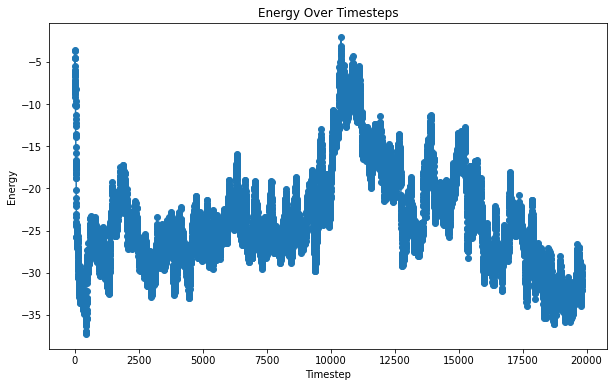

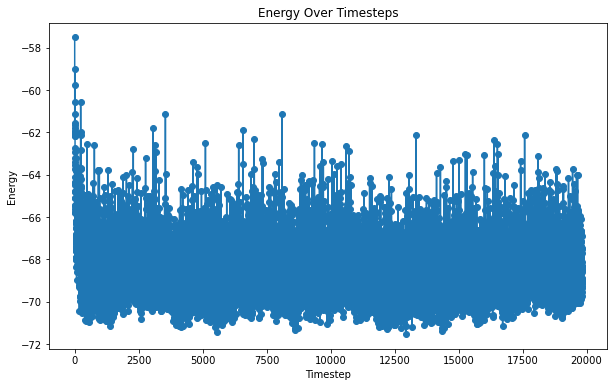

In [30]:
plot_energy(np.clip(eentraj[-19820:],-1000,  100000))
plot_energy(np.clip(eDetraj[-19820:],-1000,  100000) )  


In [70]:
view = visualize_coordinates(trajectory[-10].reshape(-1,3), scale=10.0)
view

NGLWidget()

In [71]:
view = visualize_coordinates(Dtrajectory[-10].reshape(-1,3), scale=1.0e1)
view

NGLWidget()

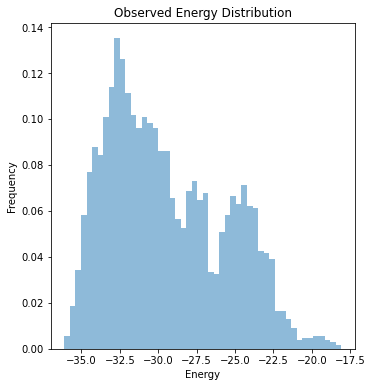

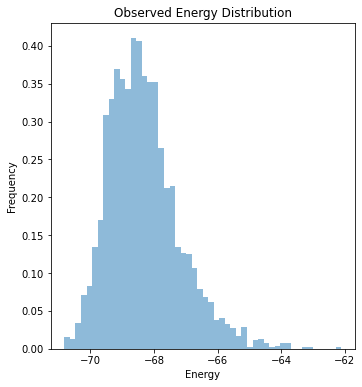

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def boltzmann_distribution(E, beta, alpha):
    return np.exp(-beta * E + alpha)

# Assume etraj is your list of energies from the simulation
energy = eentraj[-3000:]
energy2 = eDetraj[-3000:]

# Parameters beta and alpha
beta = 1.0
alpha = 0.0

# Step 1: Compute the Boltzmann distribution for the range of energies in etraj
E_range = np.linspace(min(energy), max(energy), len(energy))
P_E = boltzmann_distribution(E_range, beta, alpha)

# Step 2: Create a histogram of etraj
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(energy, bins=50, density=True, alpha=0.5, label="Observed (etraj)")#,range=[-511, -470])#,range=[-400, -340.5])
plt.title("Observed Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")


# Step 2: Create a histogram of etraj
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(energy2, bins=50, density=True, alpha=0.5, label="Observed (etraj)")#,range=[-511, -470])#,range=[-30, 30])#,range=[-400, -340.5])
plt.title("Observed Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")
# # Step 3: Plot the Boltzmann distribution
# plt.subplot(1, 2, 2)
# plt.plot(energy, P_E, label="Boltzmann Distribution")
# plt.title("Theoretical Boltzmann Distribution")
# plt.xlabel("Energy")
# plt.ylabel("P(E)")

plt.show()


In [1164]:
# plot_energy(ft_list[-2000:])

In [779]:
# plot_energy(Dft_list[-2000:])

In [1165]:
eentraj[-200:]

[41.579580515291624,
 43.20205233154457,
 50.96142475430544,
 58.91715726237012,
 65.56090394832007,
 70.13075519521482,
 55.89567542608874,
 44.146382509260334,
 30.862819243128328,
 39.61179332055752,
 44.46187203740579,
 60.752115541904416,
 71.2769336075032,
 72.50352453448394,
 53.38320426273149,
 60.32985177004145,
 36.14352153779195,
 24.79734417879732,
 20.052931251689674,
 17.611361650412544,
 17.110836610530118,
 19.31055107104173,
 10.457480881440652,
 14.344351649661586,
 21.08591796401875,
 13.975794323506125,
 18.629322167780415,
 13.044818449878537,
 10.999917494095767,
 8.844796557325036,
 6.928822813651656,
 10.205111184424942,
 4.950548828978089,
 4.861130682391359,
 3.9452204753758338,
 6.852315370973884,
 9.019300744399104,
 12.521025509620394,
 11.291320134488561,
 12.885237706290523,
 19.956538741346407,
 15.770863588792519,
 17.469522935143225,
 16.043145027377747,
 15.566565067016752,
 14.390865833235914,
 15.305016957334113,
 15.052631103275042,
 13.84940690534

In [1278]:
eDetraj[-200:]

[1.763073050028297e+23,
 6.593637541887437e+21,
 4.831986876698236e+21,
 1.37074260102988e+24,
 5.949661596967192e+17,
 8.078111406196591e+23,
 1.5139898990925201e+19,
 3.5734426605617844e+24,
 5.2780781129941274e+20,
 1.9995959792968102e+18,
 2.238268878874812e+22,
 7.800094444616185e+20,
 2.198654948653438e+19,
 3.963235086277031e+20,
 1.1656811762139597e+19,
 5.642044088222306e+18,
 6.398186413025674e+20,
 1.4642239104509002e+19,
 1.5228570245226492e+19,
 1.108158083756569e+21,
 4.0970962638041947e+20,
 1.2205283644488403e+19,
 7.153091822215004e+18,
 3.1028112929940775e+21,
 2.1255826968082954e+26,
 9.753710059766856e+18,
 1.2893436226369387e+20,
 4.143414772359271e+18,
 1.0469668136644887e+21,
 1.3913999749368078e+20,
 1.1967323451683842e+20,
 1.2035664899361845e+21,
 2.4070983091096257e+21,
 8.10118204224224e+17,
 7.388593109217859e+21,
 1.0752707104339402e+18,
 5.275439731703389e+20,
 1.2242961369249185e+18,
 1.7654381015095083e+25,
 7.742284941674745e+19,
 3.782911666894951e+19

In [770]:
'''
so, what this does, is it adds to the theory of brownian, or langevin dynamics, how to modify
covariance matrix of gaussian to sample specific ensembles. or geometries. especially,  when other constraints are present,
one needs a way to diffuse along the null space better!
'''

'\nso, what this does, is it adds to the theory of brownian, or langevin dynamics, how to modify\ncovariance matrix of gaussian to sample specific ensembles. or geometries. \n'

In [1258]:
trajectory[-10]

array([   6785.2562882 ,   61039.89820197,   27129.64817594,
          6781.8785852 ,   61041.37397708,   27130.06359504,
        -86476.49377388, -142427.52377346,   10172.73736212,
          6782.55679408,   61041.2983565 ,   27131.44971332,
          6783.1515599 ,   61041.02923749,   27130.78471354,
          6781.89760782,   61041.55318453,   27132.11701149,
        -86478.64758372, -142433.80966268,   10174.10329054,
        -86477.1159347 , -142416.57385151,   10168.22988941,
          6786.17966379,   61039.44648586,   27129.13120879,
        142427.86863885, -142425.33494585, -142424.86796017,
        -86477.49283256, -142426.46256677,   10171.76393348,
          6787.72242769,   61039.16723682,   27128.36662486,
          6787.12706834,   61040.04119015,   27129.10965137,
        142429.90097116,  162773.63652125, -142424.84054561,
          6784.11695733,   61040.47694748,   27129.89825287])

Generated constraints: set()


/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/l/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


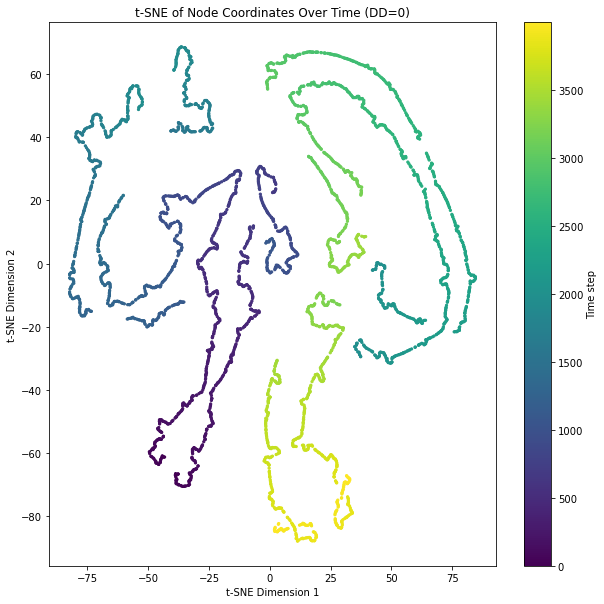

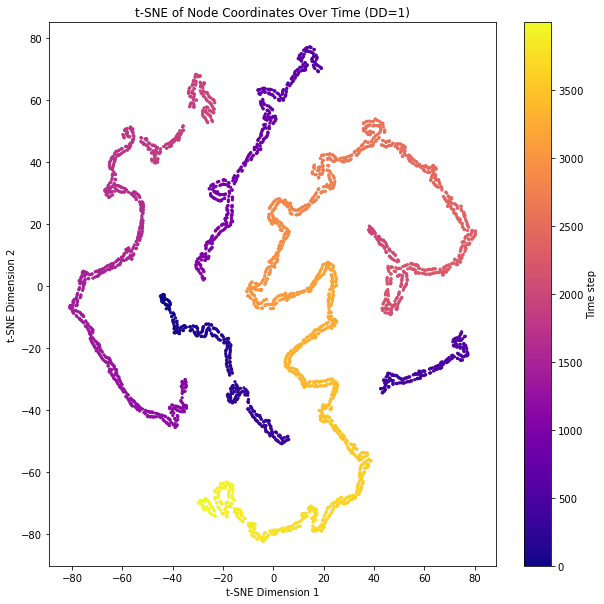

In [67]:
'''
implicit boltzman distribution
'''

def plot_energy(e):    
    # Generate the timesteps
    timesteps = list(range(len(e)))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(timesteps, e, marker='o', linestyle='-')

    # Label the axes and the plot
    plt.xlabel('Timestep')
    plt.ylabel('Energy')
    plt.title('Energy Over Timesteps')

    # Show the plot
    return plt.show()
# Function to compute the nullspace using SVD
def svd_nullspace(A, atol=1e-3, rtol=0):
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s > tol).sum()
    ns = vh[nnz:].conj().T
    return ns
def lennard_jones(r):
    # Original Lennard-Jones terms
    E_LJ = 4 * ((1 / r)**12 - (1 / r)**6)
    grad_E_LJ = 4 * (-12 / r**13 + 6 / r**7)
    
    # Additional Sinusoidal term
    E_sine = np.sin(5 * np.pi * r)
    grad_E_sine = 5 * np.pi * np.cos(5 * np.pi * r)

    # Higher-order polynomial term
    E_poly = 0.1 * r**4 - 0.2 * r**2
    grad_E_poly = 0.4 * r**3 - 0.4 * r
    
    # Interaction factor with sine and polynomial
    E_interact = 0.05 * E_sine * E_poly
    grad_E_interact = 0.05 * (grad_E_sine * E_poly + E_sine * grad_E_poly)
    
    # Combined Energy and its gradient
    E_combined = E_LJ + E_sine + E_poly + E_interact
    grad_E_combined = grad_E_LJ + grad_E_sine + grad_E_poly + grad_E_interact
    
    
    return E_combined, grad_E_combined

def simulate_LJ(x):
    M, N = x.shape
    grad_V_LJ = np.zeros((M, N))
    Esum = 0.0  # Initialize the sum of all Lennard-Jones potentials

    for i in range(M):
        for j in range(i + 1, M):
            dist_ij = np.linalg.norm(x[i] - x[j])
            E, grad_E = lennard_jones(dist_ij)
            Esum += E  # Add the potential to the sum

            direction = (x[i] - x[j]) / dist_ij
            force = grad_E * direction
            grad_V_LJ[i] += force
            grad_V_LJ[j] -= force  # Newton's third law

    return grad_V_LJ, Esum
import numpy as np
def svd_nullspace(A, atol=1e-3, rtol=0):
    u, s, vh = np.linalg.svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s > tol).sum()
    ns = vh[nnz:].conj().T
    return ns



def simulate_p(DD = 0,constraints_dict=None, beta = 1.0, alpha = 100.0 ):
    # Simulation Parameters
    T = 20000
    M = 25  # Number of nodes
    N = 3  # Number of dimensions
    D = 0.01#0.022  # Diffusion coefficient
    dt = 0.01  # Time step
#     constraints_dict = {(1, 2), (2, 3), (3, 4), (1,4), (1,3), (0,4)}  # Constraint pairs
    num_atoms = M
    prob_list = [[0, 1.0], [1, 0.0], [2, 0.0], [3, 0.0]]
    if constraints_dict is None:
        constraints_dict = generate_random_adjacency(num_atoms, prob_list)
        print("Generated constraints:", constraints_dict)
    # Initialize positions of nodes in N dimensions
    x = np.random.rand(M, N)
    trajectory = [x.flatten().copy()]
    distances = []
    distance_vector = np.zeros(len(constraints_dict))
    etraj = []
    ft_list = []

    for t in range(T):
        # Initialize constraint gradient matrix and constraint value vector
        A_matrix = np.zeros((len(constraints_dict) + 1, M * N))
        b_vector = np.zeros(len(constraints_dict) + 1)
        Esum = 0

        for idx, (i, j) in enumerate(constraints_dict):
            dist_ij = np.linalg.norm(x[i] - x[j])
            constraint_value = dist_ij ** 2 - 1
            gradient_ij = 2 * (x[i] - x[j])
            A_matrix[idx, i * N:(i + 1) * N] = gradient_ij
            A_matrix[idx, j * N:(j + 1) * N] = -gradient_ij
            b_vector[idx] = constraint_value
            distance_vector[idx] = dist_ij

        # SVD for solving Lagrange multipliers
        u, s, vh = np.linalg.svd(A_matrix @ A_matrix.T)
        lambda_vector = vh.T @ np.linalg.inv(np.diag(s) + 1e-12) @ u.T @ b_vector
        
        # Compute drift term (mu)
        mu = np.sum(A_matrix.T * lambda_vector, axis=1)

        # Calculate the gradient of the Lennard-Jones potential for all pairs
        grad_V_LJ, Esum = simulate_LJ(x) #np.ones_like(simulate_LJ(x))
        grad_V_LJ = np.clip(grad_V_LJ,-2,2)

        ################3
        ft_value = - (1 + beta) * (-Esum) + alpha + 1  # Using -Esum as the log likelihood
        ft_gradient = (1 + beta) * grad_V_LJ.flatten()  # Flatten the gradient to fit into A_matrix
        ft_list.append(ft_value.copy())
        # Insert the Boltzmann constraint into A_matrix and b_vector
        A_matrix[-1, :] = -ft_gradient*1.0e-5
#         b_vector[-1] = ft_value*1.0e-5
        #############################
        
#         etraj.append(Esum.copy())
        
#         grad_V_LJ = np.clip(grad_V_LJ,-10,10)
#         print(grad_V_LJ)
        # Flatten the gradient to match dimensions
#         grad_V_LJ_flatten = grad_V_LJ.flatten()

        # Find nullspace using SVD
        NN = svd_nullspace(A_matrix)
        
        # Project the gradient onto the nullspace
#         grad_V_projected = NN @ (NN.T @ grad_V_LJ_flatten)
        ft_gradient_projected = NN @ (NN.T @ ft_gradient)

        # Update mu to include the projected LJ gradient
        mu +=  ft_gradient_projected # + grad_V_projected# +
        # Assume mu is a numpy array with shape (M * N,)
        mu_mean = np.mean(mu.reshape(-1, N), axis=0)  # Calculate the mean for each dimension
        mu_centered = mu.reshape(-1, N) - mu_mean  # Subtract the mean from each component
        mu = mu_centered.flatten() 
        # Update positions
        D_t = D * NN @ NN.T
        if DD == 0:
            D_t = D*np.eye(D_t.shape[0])/5

        dx = np.random.multivariate_normal(- mu * dt, 2 * D_t * dt )
        dx_reshaped = dx.reshape(M, N)  # Reshape dx into (M, N) dimensions
        x = x + dx_reshaped

        # Store trajectory
        trajectory.append(x.flatten().copy())
        distances.append(distance_vector.copy())
        etraj.append(Esum.copy())

    return trajectory, distances, constraints_dict, etraj, ft_list


trajectory, distances, constraints_dict, eentraj, ft_list = simulate_p(DD = 0, constraints_dict=None)
Dtrajectory, Ddistances, constraints_dict, eDetraj, Dft_list = simulate_p(DD = 1, constraints_dict=constraints_dict)

plotts = 4000

# Convert trajectory to numpy array and apply t-SNE
trajectory = np.array(trajectory[-plotts:])
Dtrajectory = np.array(Dtrajectory[-plotts:])
entraj = np.array(eentraj[-plotts:])
Detraj = np.array(eDetraj[-plotts:])

# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=0)

# Perform t-SNE transformation
tsne_results = tsne.fit_transform(trajectory)
Dtsne_results = tsne.fit_transform(Dtrajectory)

# Plotting t-SNE results for DD=0
plt.figure(figsize=(10, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=range(len(tsne_results)), cmap='viridis', s=5)
plt.colorbar(label='Time step')
plt.title("t-SNE of Node Coordinates Over Time (DD=0)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# Plotting t-SNE results for DD=1
plt.figure(figsize=(10, 10))
plt.scatter(Dtsne_results[:, 0], Dtsne_results[:, 1], c=range(len(Dtsne_results)), cmap='plasma', s=5)
plt.colorbar(label='Time step')
plt.title("t-SNE of Node Coordinates Over Time (DD=1)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

# distances = np.array(distances)[-plotts:]

#     # Plotting the distances over time for each constraint
#     fig, axes = plt.subplots(1, len(constraints_dict), figsize=(15, 5))
#     for ax, ((i, j), distance_vector) in zip(axes, zip(constraints_dict, distances.T)):
#         ax.plot(distance_vector)
#         ax.set_title(f"Constraint Pair ({i}, {j})")
#         ax.set_xlabel('Time step')
#         ax.set_ylabel('Distance')

#     plt.tight_layout()
#     plt.show()
#     Ddistances = np.array(Ddistances)[-plotts:]

#     # Plotting the distances over time for each constraint
#     fig, axes = plt.subplots(1, len(constraints_dict), figsize=(15, 5))
#     for ax, ((i, j), distance_vector) in zip(axes, zip(constraints_dict, Ddistances.T)):
#         ax.plot(distance_vector)
#         ax.set_title(f"Constraint Pair ({i}, {j})")
#         ax.set_xlabel('Time step')
#         ax.set_ylabel('Distance')

#     plt.tight_layout()
#     plt.show()


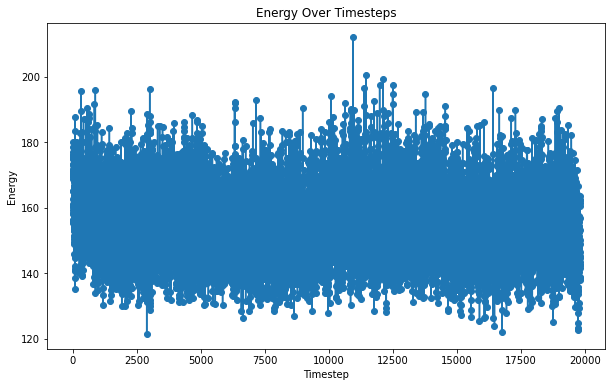

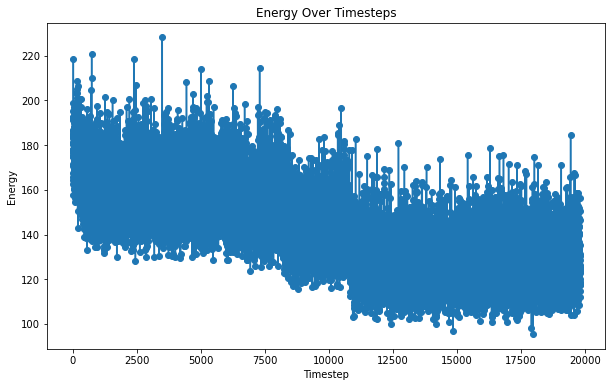

In [68]:
plot_energy(np.clip(eentraj[-19800:],-1000,  100000))
plot_energy(np.clip(eDetraj[-19800:],-1000,  100000) )  


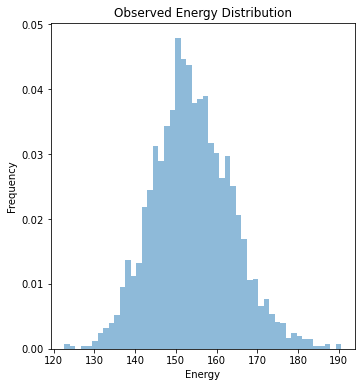

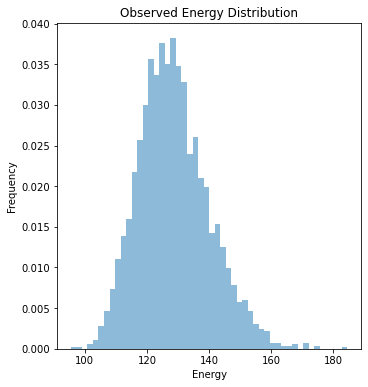

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def boltzmann_distribution(E, beta, alpha):
    return np.exp(-beta * E + alpha)

# Assume etraj is your list of energies from the simulation
energy = eentraj[-3000:]
energy2 = eDetraj[-3000:]

# Parameters beta and alpha
beta = 1.0
alpha = 0.0

# Step 1: Compute the Boltzmann distribution for the range of energies in etraj
E_range = np.linspace(min(energy), max(energy), len(energy))
P_E = boltzmann_distribution(E_range, beta, alpha)

# Step 2: Create a histogram of etraj
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(energy, bins=50, density=True, alpha=0.5, label="Observed (etraj)")#,range=[-511, -470])#,range=[-400, -340.5])
plt.title("Observed Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")


# Step 2: Create a histogram of etraj
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(energy2, bins=50, density=True, alpha=0.5, label="Observed (etraj)")#,range=[-511, -470])#,range=[-30, 30])#,range=[-400, -340.5])
plt.title("Observed Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Frequency")
# # Step 3: Plot the Boltzmann distribution
# plt.subplot(1, 2, 2)
# plt.plot(energy, P_E, label="Boltzmann Distribution")
# plt.title("Theoretical Boltzmann Distribution")
# plt.xlabel("Energy")
# plt.ylabel("P(E)")

plt.show()
